# Self Attention 人聲辨識

利用一段人聲來進行語音辨識確認說話者
資料來源: https://www.kaggle.com/t/49ea0c385a974db5919ec67299ba2e6b

### Self-Attention
自我注意力（self-attention）是機器學習中一項關鍵技術，特別是在自然語言處理領域中廣泛應用。它允許模型在處理序列數據時，對輸入的不同部分分配不同的注意力權重。具體來說，自我注意力機制能夠使模型在計算特定位置的表示時，同時考慮輸入序列中其他所有位置的信息，從而使得模型能夠更好地理解整個序列的語義結構。通過學習輸入序列中各個位置之間的關係，模型能夠更有效地捕捉上下文信息，並產生更準確的輸出。在自我注意力機制中，注意力權重是通過對輸入序列中各個位置的表示進行加權求和來計算的，其中權重由模型自動學習得出。因此，自我注意力機制使得模型能夠在不同位置上動態地聚焦於序列中的不同部分，從而提高了模型的表達能力和性能。
主要是因為在語音辨識時或將聲音切為許多的簡短音訊，而在輸入是很多段的音訊(matrix)之下，進行多個輸入-> 一個輸出(或是多個輸出)，就會用到self attention的方法，與一般輸入只有一段matrix的做法不同。

1. 資料解壓縮、匯入 dataset & dataloader
2. 建立 Model
3. Learning rate schedule
4. Training loop & testing loop
5. 調整 Model & Warm up
6. 模型儲存
7. Inference
8. 結論

## 1. 資料解壓縮、匯入 dataset & dataloader

In [4]:
import os
import tarfile

In [5]:
os.getcwd()

'C:\\Users\\HSUPC'

In [6]:
os.chdir('C:\\Users\\HSUPC\\python_files\\ML2023HW4')

In [ ]:
with tarfile.open('Dataset.tar.gz') as rawdata:
    rawdata.extractall()

In [7]:
import json
import numpy as np
import torch
import random
import torch.nn as nn
from torch.utils.data import Dataset
import pathlib

In [8]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [9]:
class Voxdataset(Dataset):

    '''
    Data Structure:
    data file: 'C:\\Users\\HSUPC\\python_files\\ML2023HW4\\Dataset'
        1. mapping.json: 
            speaker2id ("id00464": 0, "id00559": 1, "id00578": 2)
            id2speaker ("0": "id00464", "1": "id00559", "2": "id00578")
        2. metadata.json: training data 的 signal
            {
                "n_mels": 40,
                "speakers": {
                    "id03074": [
                        {
                            "feature_path": "uttr-18e375195dc146fd8d14b8a322c29b90.pt",
                            "mel_len": 435
                        },
                        {
                            "feature_path": "uttr-fe3576f81b5841ab8931c1dd611bf547.pt",
                            "mel_len": 344
                    },...
        3. testdata.json:
            Similar as metadata.json only this is for testing data and without speakers(id).
            {
                "n_mels": 40,
                "utterances": [
                    {
                        "feature_path": "uttr-c943514d1fae4ae983d10e8987856b13.pt",
                        "mel_len": 452
                    },
                    {
                        "feature_path": "uttr-f8affff33d5c451c9b5856bd4764f4d9.pt",
                        "mel_len": 546
                    },...
        4. uttr-.*.pt

    '''

    def __init__(self, data_dir, segment_len = 128):

        '''
        * 128 為常見的mel頻譜的長度
        1. Load mapping data for speaker2id
        2. Load metadata or testdata
        3. Num of speaker
        4. Return a list with [file, speaker id] for __len__ and __getitem__
        '''

        self.data_dir = data_dir
        self.segment_len = segment_len

        # Load mapping.json
        mapping_path = pathlib.Path(data_dir)/'mapping.json'
        mapping = json.load(mapping_path.open())
        self.speaker2id = mapping['speaker2id']

        # Load metadata.json
        meta_path = pathlib.Path(data_dir)/'metadata.json'
        metadata = json.load(meta_path.open())['speakers']

        # the number of speaker in data
        self.speaker_num = len(metadata.keys())

        # return a list self.data that includes [[name of feature_path1, speaker id1], [name of feature_path2, speaker id2]...]
        self.data = []
        for speakers in metadata.keys():
            for utterances in metadata[speakers]:
                self.data.append([utterances['feature_path'], self.speaker2id[speakers]])

    
    def __len__(self):
        # return the number of data
        return len(self.data)
        

    def __getitem__(self, idx):
        # Get the indexth item from the dataset, first read the preprocessed mel-spectrogram (pt file)
        feature_path, speaker = self.data[idx]
        speaker = torch.LongTensor([speaker])
        mel = torch.load(pathlib.Path(self.data_dir)/feature_path)

        # As the length of mel-spectrogram is decided in the beginning as an input variable, trim if the length of selected mel-spectrogram is larger.
        if len(mel) > self.segment_len:
            mel_start = random.randint(0, (len(mel) - self.segment_len))
            return torch.FloatTensor(mel[mel_start : mel_start + self.segment_len]), speaker
        else:
            return torch.FloatTensor(mel), speaker


    def speaker_num(self):
        return self.speaker_num
         

In [10]:
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

In [11]:
def collate_batch(batch):
    '''
    Since the length in each mel is different, need to pad them to the same length.
    This is used in Dataloader as a vaiable in collact_fn.
    '''
    mel, speaker = zip(*batch)
    # padding output: Batch * padded mel length * 40, padding value = 20
    mel = pad_sequence(mel, batch_first= True, padding_value= -20)
    return mel, torch.LongTensor(speaker)

In [12]:
# Split the dataset to train_data (90%) and valid_data (10%)
metadata = Voxdataset('Dataset')
train_data, valid_data = random_split(
    metadata, 
    [int(len(metadata)*.9), len(metadata)-int(len(metadata)*.9)], 
    generator= torch.Generator().manual_seed(42)
)

In [13]:
# Create dataloader for train and valid data with each batch size = 128 and collate_fn based on previous setting.
train_loader = DataLoader(train_data, batch_size = 128, shuffle = True, collate_fn = collate_batch)
valid_loader = DataLoader(valid_data, batch_size = 128, shuffle = False, collate_fn = collate_batch)

## 2. 建立 Model

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [66]:
class VoxModel(nn.Module):

    '''
    nn.TransformerEncoderLayer 包含 self-attn 與 feedforward netword 架構
    主要參數包含:
    d_model : input
    n_head : 若大於 1 則為 multihead self-attn，multi-head self-attn 有助於提高輸入向量間有複雜關聯關係的資料的模型表現。
    dim_feedforward : 在 self-attn 計算完輸入向量之間的關聯性後softmax, norm 後接上 fully connected neuron network。
        dim_feedforward 決定 FNN 中的 hidden layer 的 neuron 數。\
    batch_first : defult = False 當 batch_fist 為 False 時，layer 的輸入與輸出都是 (length * batch size * d_model)
        這邊改成 True 以這個 dataset 來說比較好操作。
    
    '''

    def __init__(self, d_model, n_spks):
        super().__init__()
        # 將 input shape project 到 encoder 中 d_model 的大小
        self.prenet = nn.Linear(40, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead= 2, dim_feedforward= 256, batch_first= True)
        self.pred_layer = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Sigmoid(),
            nn.Linear(d_model, n_spks)
        )
        
    def forward(self, x):
        '''
        input shape: batch size * length * 40
        output shape: batch size * n_spks
        '''
        out = self.encoder_layer(self.prenet(x))
        # 對 output 進行 mean pooling 後丟進 pred_layer 進行最後的 linear layers
        return self.pred_layer(out.mean(dim = 1))
        
        

In [101]:
test_loader = DataLoader(train_data, batch_size = 64)

In [102]:
test1, label1 = next(iter(test_loader))

In [103]:
test1.shape

torch.Size([64, 128, 40])

In [108]:
label1.shape

torch.Size([64, 1])

In [79]:
testmodel = VoxModel(d_model = 32, n_spks= metadata.speaker_num)
summary(testmodel, (64, 128, 40))

Layer (type:depth-idx)                   Output Shape              Param #
VoxModel                                 [64, 600]                 --
├─Linear: 1-1                            [64, 128, 32]             1,312
├─TransformerEncoderLayer: 1-2           [64, 128, 32]             21,024
├─Sequential: 1-3                        [64, 600]                 --
│    └─Linear: 2-1                       [64, 32]                  1,056
│    └─Sigmoid: 2-2                      [64, 32]                  --
│    └─Linear: 2-3                       [64, 600]                 19,800
Total params: 43,192
Trainable params: 43,192
Non-trainable params: 0
Total mult-adds (M): 1.42
Input size (MB): 1.31
Forward/backward pass size (MB): 2.42
Params size (MB): 0.09
Estimated Total Size (MB): 3.82

In [105]:
testmodel = testmodel.to('cpu')
output_t = testmodel(test1)

In [106]:
output_t.shape

torch.Size([64, 600])

In [87]:
pred_t = torch.argmax(output_t, dim = 1)
pred_t.shape

torch.Size([64])

In [124]:
loss = loss_fn_t(output_t, label1.squeeze())
loss

tensor(6.4611, grad_fn=<NllLossBackward0>)

## 3. Learning Rate Schedule

在做 transformer 的訓練時，證實 learning rate 的 warm-up 是有助於模型訓練，這裡加入 learning rate warm-up。
Transformer 模型中的學習率預熱（learning rate warm-up）是一種用於在訓練初始階段逐漸增加學習率的策略，其目的是幫助模型更好地適應訓練數據，並且在開始時不會因為過大的學習率導致不穩定或不良的收斂行為。

這裡的 learning rate warm up 先用 linear的方式增加 learning rate 後，等 warm-up iter結束後，用cosine alleaning 的方式開始遞減。

In [144]:
import math

In [146]:
def get_cosine_schedule_with_warmup(
    optimitzer: torch.optim.Optimizer, # optimitzer
    num_warmup: int, # warm-up 階段中 steps 次數
    num_training_steps: int, # training 階段中 steps 次數
    num_cycles: float = 0.5,  # cosine 的 cycle wave
    last_epoch: int = -1 # 定位最後一次的 epoch 來做 traning，是tprch.optim.lr_scheduler.LambdaLR 的輸入值，預設為 -1
):
    '''
    先定義 lr_lambda，當 input current_step後去比較是否完成 wamr up:
    * 如果還沒完成 warm-up (current_step < num_warmup) -> lr = current_step / num_warmup
    * 如果完成 warm-up -> 計算 (current_step - num_warmup)/(num_training_steps - num_warmup) 先算在除去 warm-up 後目前是第幾次 iter
        以此作為參數計算 cosine alleaning -> math.cos(math.pi*num_cycles*2*progress)
    
    '''

    def lr_lambda(current_step):
        # warm-up
        if current_step < num_warmup:
            return float(current_step)/float(max(1, num_warmup))

        # decay 如果 Current step = 13, num_warmup = 10, num_training = 100 -> float (13-10)/float(max(1, 90)
        progress = float(current_step - num_warmup)/ float(max(1, num_training_steps - num_warmup))
        

        return max(0.0, 
                   0.5*(1.0 + math.cos(math.pi*float(num_cycles*2.0*progress))))

    return torch.optim.lr_scheduler.LambdaLR(optimitzer, lr_lambda)



## 4. Training Loop & Testing loop

先看如果沒有用 learning rate schedule 的表現如何:

In [139]:
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [150]:
def train_loop(model, loss_fn, optimizer, train_loader = train_loader, device = 'cuda', scheduler = None):

    train_loss, train_total, train_acc = 0, 0, 0

    for mel, label in train_loader:
        
        mel, label = mel.to(device), label.to(device)
        model = model.to(device)

        output = model(mel)
        loss = loss_fn(output, label.squeeze())
        pred = torch.argmax(output, dim = 1)
            
        train_loss += loss.item()
        train_total += len(label)
        train_acc += int((pred == label).sum())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()
            

    return train_loss/train_total, train_acc/train_total
        

In [151]:
def test_loop(model, loss_fn, test_loader = valid_loader, device = 'cuda'):

    test_loss, test_total, test_acc = 0, 0, 0

    with torch.inference_mode():

        for mel, label in test_loader:
    
            mel, label = mel.to(device), label.to(device)
    
            test_output = model(mel)
            t_loss = loss_fn(test_output, label.squeeze())
            t_pred = torch.argmax(test_output, dim = 1)
    
            test_loss += t_loss.item()
            test_total += len(label)
            test_acc += int((t_pred == label).sum())

    return test_loss/test_total, test_acc/test_total      
        



In [157]:
def train_test_loop(n_epoch, model, loss_fn, optimizer, train_loader = train_loader, test_loader = valid_loader, device = 'cuda', scheduler = None ):

    train_loss, train_acc, test_loss, test_acc = [], [], [], []
    
    for epoch in tqdm(range(n_epoch)):

        train_loss1, train_acc1 = train_loop(model, loss_fn, optimizer, train_loader = train_loader, device = 'cuda', scheduler = scheduler)
        test_loss1, test_acc1 = test_loop(model, loss_fn, test_loader = valid_loader, device = 'cuda')

        train_loss.append(train_loss1)
        train_acc.append(train_acc1)
        test_loss.append(test_loss1)
        test_acc.append(test_acc1)

    #plotting
    plt.figure(figsize = (10,4))
    plt.subplot(1,2,1)
    plt.plot(range(len(train_loss)), train_loss, label = 'Train Loss')
    plt.plot(range(len(train_loss)), test_loss, label = 'Test Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(len(train_loss)), train_acc, label = 'Train Accuracy')
    plt.plot(range(len(train_loss)), test_acc, label = 'Test Accuracy')
    plt.legend()
    plt.tight_layout()

    return train_loss, train_acc, test_loss, test_acc
        

## 5. 調整 Model & Warm up

In [164]:
testmodel1 = VoxModel(d_model = 64, n_spks= metadata.speaker_num)

In [165]:
summary(testmodel1, (128, 128, 40))

Layer (type:depth-idx)                   Output Shape              Param #
VoxModel                                 [128, 600]                --
├─Linear: 1-1                            [128, 128, 64]            2,624
├─TransformerEncoderLayer: 1-2           [128, 128, 64]            49,984
├─Sequential: 1-3                        [128, 600]                --
│    └─Linear: 2-1                       [128, 64]                 4,160
│    └─Sigmoid: 2-2                      [128, 64]                 --
│    └─Linear: 2-3                       [128, 600]                39,000
Total params: 95,768
Trainable params: 95,768
Non-trainable params: 0
Total mult-adds (M): 5.86
Input size (MB): 2.62
Forward/backward pass size (MB): 9.07
Params size (MB): 0.18
Estimated Total Size (MB): 11.87

In [166]:
testmodel1 = VoxModel(d_model = 64, n_spks= metadata.speaker_num)
loss_fn_t = nn.CrossEntropyLoss()
optimizer_t = torch.optim.Adam(testmodel1.parameters())

  0%|          | 0/50 [00:00<?, ?it/s]

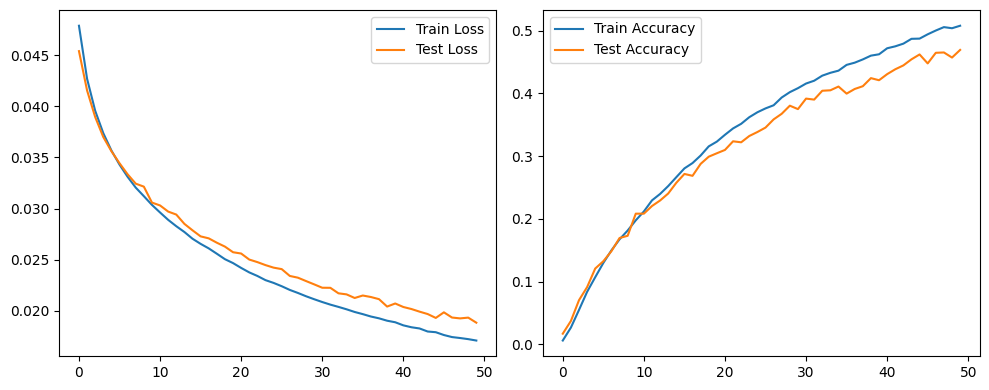

In [167]:
train_loss, train_acc, test_loss, test_acc = train_test_loop(50, testmodel1, loss_fn_t, optimizer_t)

In [168]:
testmodel1_1 = VoxModel(d_model = 256, n_spks= metadata.speaker_num)
loss_fn_t1_1 = nn.CrossEntropyLoss()
optimizer_t1_1 = torch.optim.Adam(testmodel1_1.parameters())

  0%|          | 0/100 [00:00<?, ?it/s]

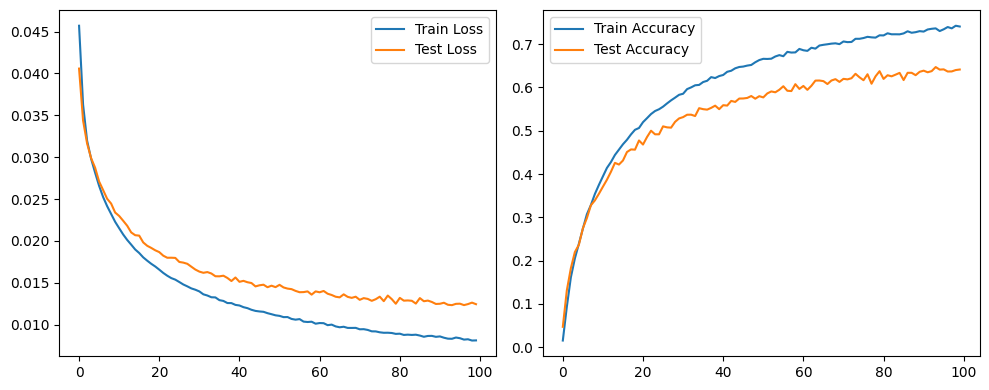

In [169]:
train_loss1_1, train_acc1_1, test_loss1_1, test_acc1_1 = train_test_loop(100, testmodel1_1, loss_fn_t1_1, optimizer_t1_1)

d_model 從64改到256後，Loss 有所下降。 使用 learning rate schedule，用較小的 d_model 試跑看看:

In [162]:
testmodel2 = VoxModel(d_model = 64, n_spks = 600)
loss_fn_t2 = nn.CrossEntropyLoss()
optimizer_t2 = torch.optim.Adam(testmodel2.parameters())
scheduler_t2 = get_cosine_schedule_with_warmup(optimizer_t2, 5, 50) 

In [159]:
summary(testmodel2, (128,128,40))

Layer (type:depth-idx)                   Output Shape              Param #
VoxModel                                 [128, 600]                --
├─Linear: 1-1                            [128, 128, 64]            2,624
├─TransformerEncoderLayer: 1-2           [128, 128, 64]            49,984
├─Sequential: 1-3                        [128, 600]                --
│    └─Linear: 2-1                       [128, 64]                 4,160
│    └─Sigmoid: 2-2                      [128, 64]                 --
│    └─Linear: 2-3                       [128, 600]                39,000
Total params: 95,768
Trainable params: 95,768
Non-trainable params: 0
Total mult-adds (M): 5.86
Input size (MB): 2.62
Forward/backward pass size (MB): 9.07
Params size (MB): 0.18
Estimated Total Size (MB): 11.87

  0%|          | 0/50 [00:00<?, ?it/s]

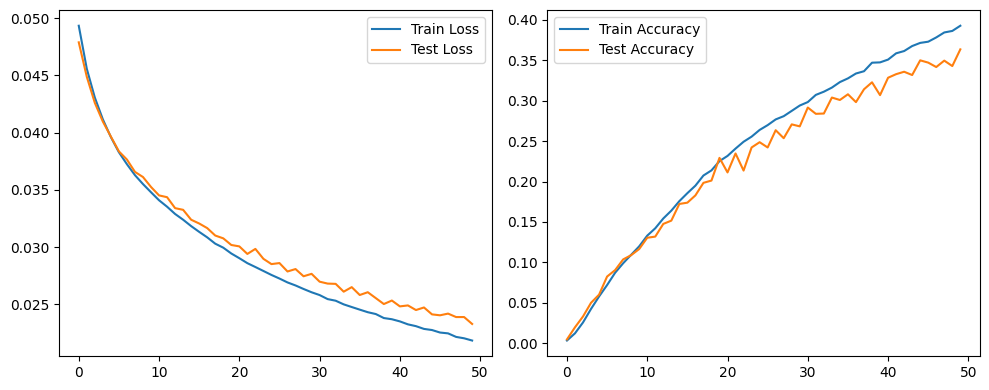

In [163]:
train_loss_t2, train_acc_t2, test_loss_t2, test_acc_t2 = train_test_loop(50, testmodel2, loss_fn_t2, optimizer_t2, scheduler = scheduler_t2)

將 d_model 從 64 改到 256:

In [172]:
testmodel2_1 = VoxModel(d_model = 256, n_spks = 600)
loss_fn_t2_1 = nn.CrossEntropyLoss()
optimizer_t2_1 = torch.optim.Adam(testmodel2_1.parameters())
scheduler_t2_1 = get_cosine_schedule_with_warmup(optimizer_t2_1, 10, 100) 

  0%|          | 0/100 [00:00<?, ?it/s]

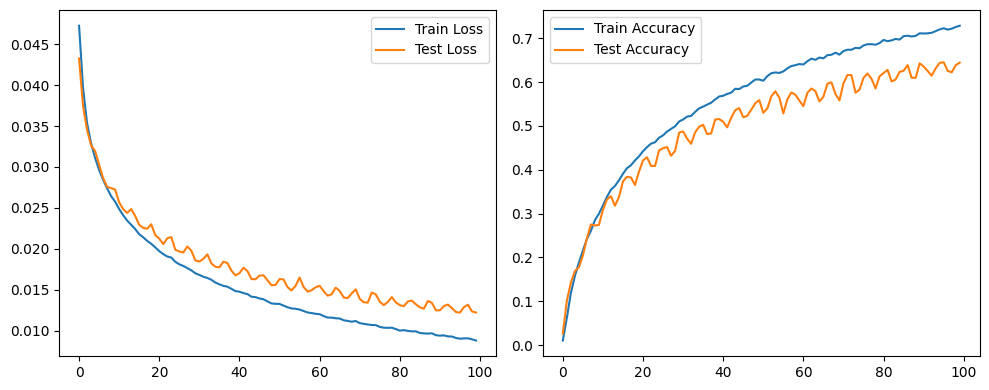

In [173]:
train_loss_t2_1, train_acc_t2_1, test_loss_t2_1, test_acc_t2_1 = train_test_loop(100, testmodel2_1, loss_fn_t2_1, optimizer_t2_1, scheduler = scheduler_t2_1)

將 optimitzer 改成 AdamW (weight decay = 0.01)

In [180]:
testmodel2_2 = VoxModel(d_model = 256, n_spks = 600)
loss_fn_t2_2 = nn.CrossEntropyLoss()
optimizer_t2_2 = torch.optim.AdamW(testmodel2_2.parameters())
scheduler_t2_2 = get_cosine_schedule_with_warmup(optimizer_t2_2, 10, 100) 

  0%|          | 0/100 [00:00<?, ?it/s]

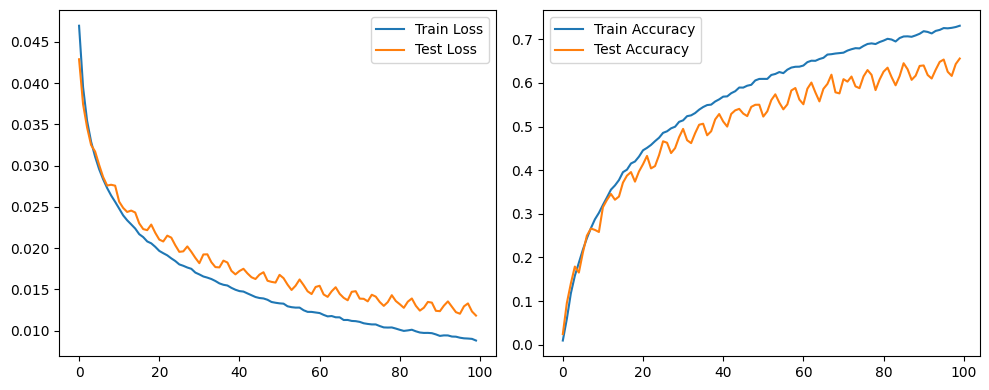

In [181]:
train_loss_t2_2, train_acc_t2_2, test_loss_t2_2, test_acc_t2_2 = train_test_loop(100, testmodel2_2, loss_fn_t2_2, optimizer_t2_2, scheduler = scheduler_t2_2)

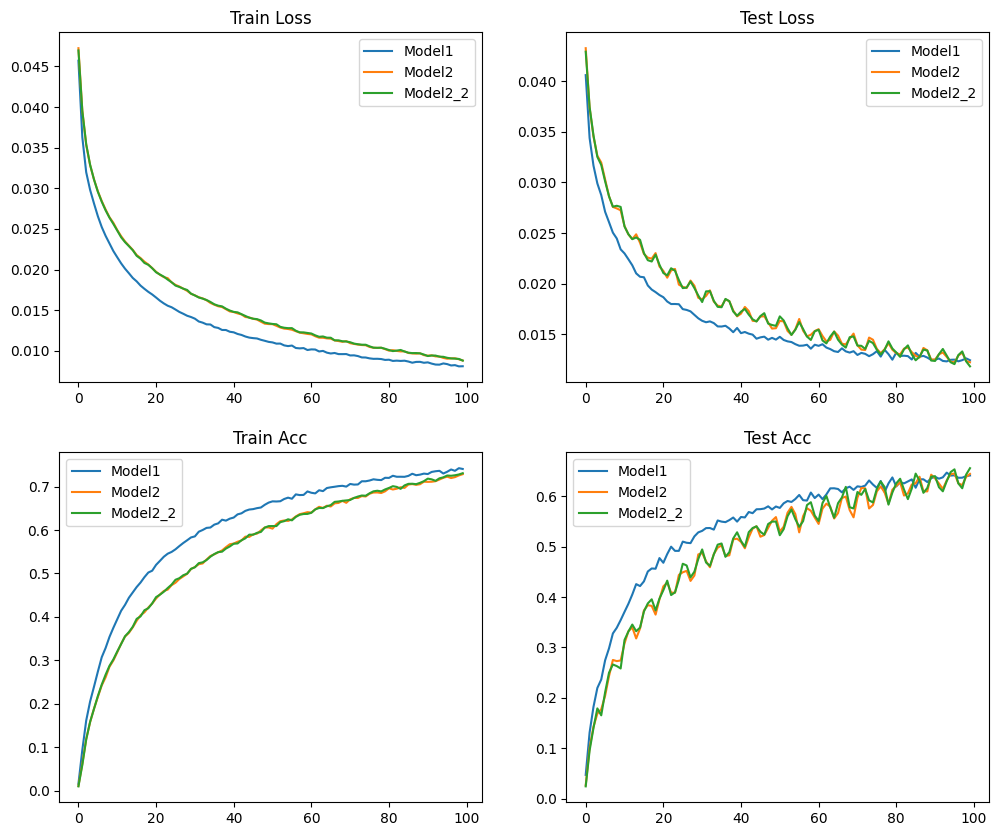

In [238]:
plt.figure(figsize = (12,10))

plt.subplot(2,2,1)
plt.plot(range(100), train_loss1_1, label = 'Model1')
plt.plot(range(100), train_loss_t2_1, label = 'Model2')
plt.plot(range(100), train_loss_t2_2, label = 'Model2_2')
plt.title('Train Loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(100), test_loss1_1, label = 'Model1')
plt.plot(range(100), test_loss_t2_1, label = 'Model2')
plt.plot(range(100), test_loss_t2_2, label = 'Model2_2')
plt.title('Test Loss')
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(100), train_acc1_1, label = 'Model1')
plt.plot(range(100), train_acc_t2_1, label = 'Model2')
plt.plot(range(100), train_acc_t2_2, label = 'Model2_2')
plt.title('Train Acc')
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(100), test_acc1_1, label = 'Model1')
plt.plot(range(100), test_acc_t2_1, label = 'Model2')
plt.plot(range(100), test_acc_t2_2, label = 'Model2_2')
plt.title('Test Acc')
plt.legend()

1. 沒使用 leanrning rate warm-up (Model1) 與 有使用 leanrning rate warm-up 的 model 相比，warm-up model的表現會比較好一些
2. Adam (Model2) 與 AdamW (Model2_2) 的表現相近

In [240]:
class VoxModel1(nn.Module):

    '''
    n_head = 2 -> 4, dim_feedforward = 256 -> 512
    '''

    def __init__(self, d_model, n_spks):
        super().__init__()
        self.prenet = nn.Linear(40, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead= 4, dim_feedforward= 512, batch_first= True)
        self.pred_layer = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Sigmoid(),
            nn.Linear(d_model, d_model),
            nn.Sigmoid(),
            nn.Linear(d_model, n_spks)
        )
        
    def forward(self, x):
        out = self.encoder_layer(self.prenet(x))
        return self.pred_layer(out.mean(dim = 1))
        

In [189]:
model3_1 = VoxModel1(d_model = 256, n_spks = 600)
loss_fn_3_1 = nn.CrossEntropyLoss()
optimizer_3_1 = torch.optim.AdamW(model3_1.parameters())
scheduler_3_1 = get_cosine_schedule_with_warmup(optimizer_3_1, 15, 200) 

  0%|          | 0/200 [00:00<?, ?it/s]

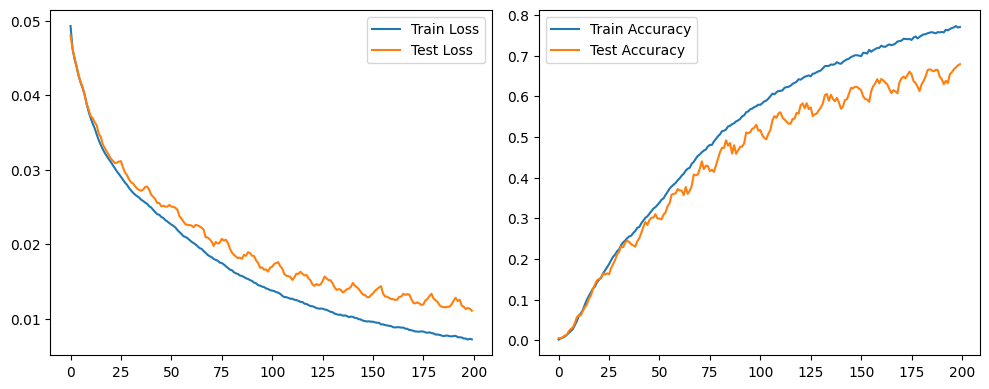

In [190]:
train_loss_3_1, train_acc_3_1, test_loss_3_1, test_acc_3_1 = train_test_loop(200, model3_1, loss_fn_3_1, optimizer_3_1, scheduler = scheduler_3_1)

增加模型複雜度後，模型表現變好。

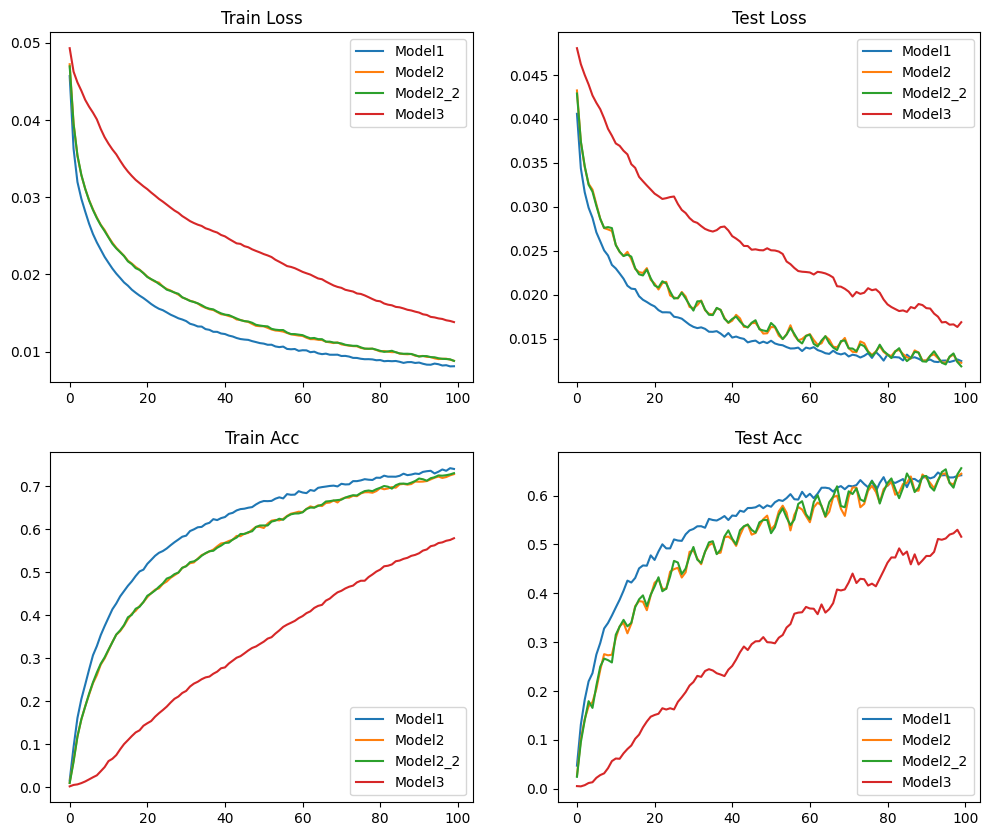

In [237]:
plt.figure(figsize = (12,10))

plt.subplot(2,2,1)
plt.plot(range(100), train_loss1_1, label = 'Model1')
plt.plot(range(100), train_loss_t2_1, label = 'Model2')
plt.plot(range(100), train_loss_t2_2, label = 'Model2_2')
plt.plot(range(100), train_loss_3_1[:100], label = 'Model3')
plt.title('Train Loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(100), test_loss1_1, label = 'Model1')
plt.plot(range(100), test_loss_t2_1, label = 'Model2')
plt.plot(range(100), test_loss_t2_2, label = 'Model2_2')
plt.plot(range(100), test_loss_3_1[:100], label = 'Model3')
plt.title('Test Loss')
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(100), train_acc1_1, label = 'Model1')
plt.plot(range(100), train_acc_t2_1, label = 'Model2')
plt.plot(range(100), train_acc_t2_2, label = 'Model2_2')
plt.plot(range(100), train_acc_3_1[:100], label = 'Model3')
plt.title('Train Acc')
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(100), test_acc1_1, label = 'Model1')
plt.plot(range(100), test_acc_t2_1, label = 'Model2')
plt.plot(range(100), test_acc_t2_2, label = 'Model2_2')
plt.plot(range(100), test_acc_3_1[:100], label = 'Model3')
plt.title('Test Acc')
plt.legend()

In [195]:
model3_2 = VoxModel1(d_model = 256, n_spks = 600)
loss_fn_3_2 = nn.CrossEntropyLoss()
optimizer_3_2 = torch.optim.AdamW(model3_2.parameters())

  0%|          | 0/200 [00:00<?, ?it/s]

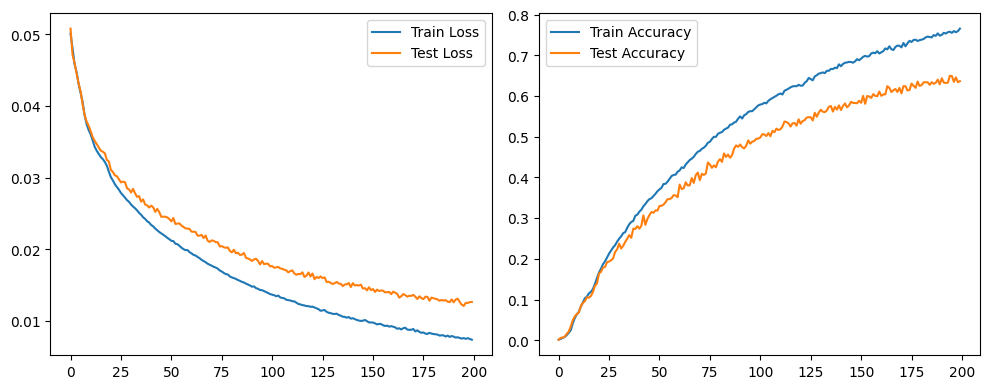

In [196]:
train_loss_3_2, train_acc_3_2, test_loss_3_2, test_acc_3_2 = train_test_loop(200, model3_2, loss_fn_3_2, optimizer_3_2)

有warm-up的模型 (Model3_1) 表現比沒有 warm-up (Model3_2) 好:

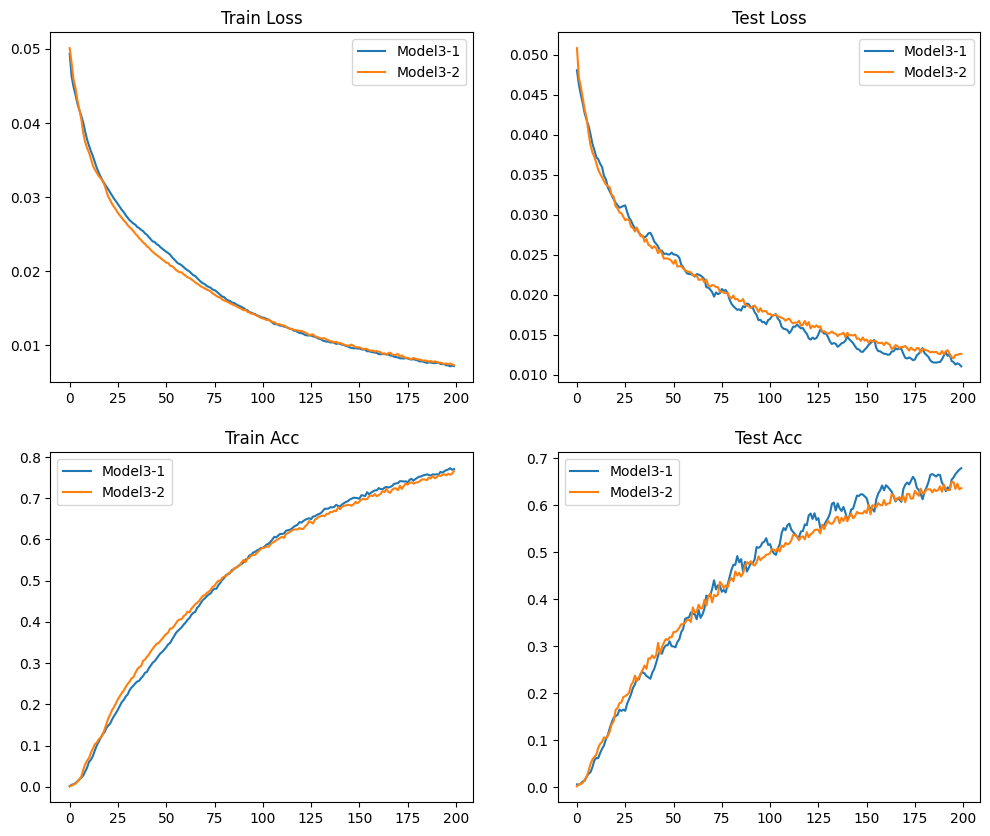

In [241]:
plt.figure(figsize = (12,10))

plt.subplot(2,2,1)
plt.plot(range(200), train_loss_3_1, label = 'Model3-1')
plt.plot(range(200), train_loss_3_2, label = 'Model3-2')
plt.title('Train Loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(200), test_loss_3_1, label = 'Model3-1')
plt.plot(range(200), test_loss_3_2, label = 'Model3-2')
plt.title('Test Loss')
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(200), train_acc_3_1, label = 'Model3-1')
plt.plot(range(200), train_acc_3_2, label = 'Model3-2')
plt.title('Train Acc')
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(200), test_acc_3_1, label = 'Model3-1')
plt.plot(range(200), test_acc_3_2, label = 'Model3-2')
plt.title('Test Acc')
plt.legend()

In [243]:
class VoxModel2(nn.Module):

    '''
    Activation = 'relu' -> 'gelu'
    '''

    def __init__(self, d_model, n_spks):
        super().__init__()
        self.prenet = nn.Linear(40, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead= 4, dim_feedforward= 512, batch_first= True, activation='gelu')
        self.pred_layer = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Sigmoid(),
            nn.Linear(d_model, d_model),
            nn.Sigmoid(),
            nn.Linear(d_model, n_spks)
        )
        
    def forward(self, x):
        out = self.encoder_layer(self.prenet(x))
        return self.pred_layer(out.mean(dim = 1))

In [203]:
model4_1 = VoxModel2(d_model = 256, n_spks = 600)
loss_fn_4_1 = nn.CrossEntropyLoss()
optimizer_4_1 = torch.optim.AdamW(model4_1.parameters())
scheduler_4_1 = get_cosine_schedule_with_warmup(optimizer_4_1, 15, 200) 

In [204]:
summary(model4_1, (128,128,40))

Layer (type:depth-idx)                   Output Shape              Param #
VoxModel2                                [128, 600]                --
├─Linear: 1-1                            [128, 128, 256]           10,496
├─TransformerEncoderLayer: 1-2           [128, 128, 256]           527,104
├─Sequential: 1-3                        [128, 600]                --
│    └─Linear: 2-1                       [128, 256]                65,792
│    └─Sigmoid: 2-2                      [128, 256]                --
│    └─Linear: 2-3                       [128, 256]                65,792
│    └─Sigmoid: 2-4                      [128, 256]                --
│    └─Linear: 2-5                       [128, 600]                154,200
Total params: 823,384
Trainable params: 823,384
Non-trainable params: 0
Total mult-adds (M): 37.92
Input size (MB): 2.62
Forward/backward pass size (MB): 34.69
Params size (MB): 1.19
Estimated Total Size (MB): 38.50

  0%|          | 0/200 [00:00<?, ?it/s]

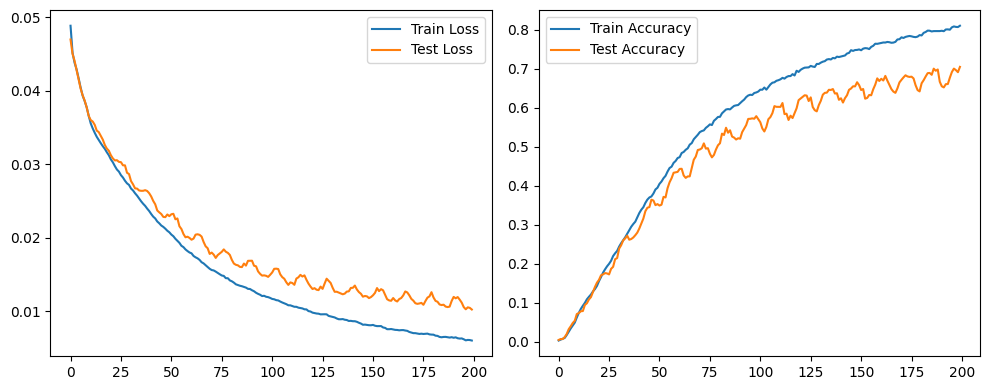

In [205]:
train_loss_4_1, train_acc_4_1, test_loss_4_1, test_acc_4_1 = train_test_loop(200, model4_1, loss_fn_4_1, optimizer_4_1, scheduler= scheduler_4_1)

Gelu performs better than relu.

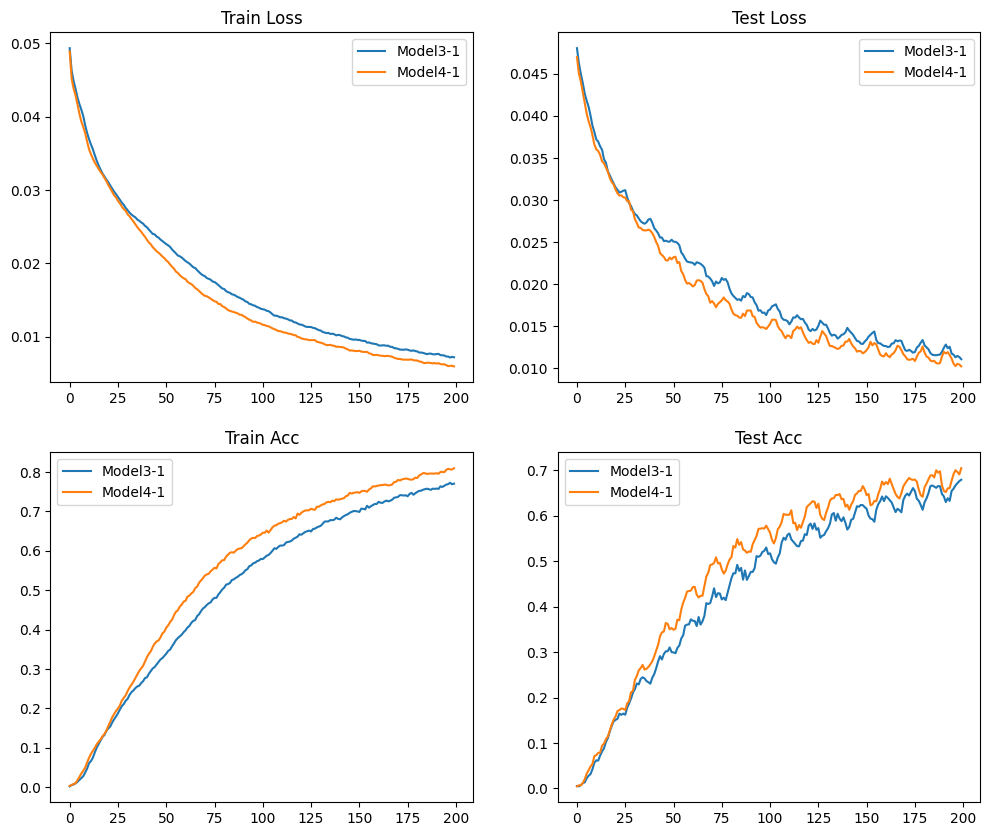

In [242]:
plt.figure(figsize = (12,10))

plt.subplot(2,2,1)
plt.plot(range(200), train_loss_3_1, label = 'Model3-1')
plt.plot(range(200), train_loss_4_1, label = 'Model4-1')
plt.title('Train Loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(200), test_loss_3_1, label = 'Model3-1')
plt.plot(range(200), test_loss_4_1, label = 'Model4-1')
plt.title('Test Loss')
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(200), train_acc_3_1, label = 'Model3-1')
plt.plot(range(200), train_acc_4_1, label = 'Model4-1')
plt.title('Train Acc')
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(200), test_acc_3_1, label = 'Model3-1')
plt.plot(range(200), test_acc_4_1, label = 'Model4-1')
plt.title('Test Acc')
plt.legend()

In [206]:
pip install conformer

   ---------------------------------------- 0.0/44.6 kB ? eta -:--:--
   --------- ------------------------------ 10.2/44.6 kB ? eta -:--:--
   --------------------------- ------------ 30.7/44.6 kB 330.3 kB/s eta 0:00:01
   ---------------------------------------- 44.6/44.6 kB 365.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [208]:
import conformer
from conformer import ConformerBlock

In [235]:
class VoxConfomer(nn.Module):

    '''
    建立 Conformer 模型:
    https://arxiv.org/pdf/2005.08100.pdf
    Conformer 模型是結合 CNN 與 Transformer 模型，並證實在處理語音辨識有較好的成效。
    模型概念:
    1. Transformer 中 Self Attention 在處理序列資料泛化能力強
    2. CNN 在處理 Local 特徵表現好
    => 結合兩者的長處成為 Conformer

    Conformer Block 架構:
    1. Feedforward
    2. Multi-head self-attn
    3. CNN
    4. Feedforward
    
    '''

    def __init__(self, d_model, n_spks):
        super().__init__()
        self.prenet = nn.Linear(40, d_model)
        self.conformer = ConformerBlock(dim = d_model, attn_dropout=0.1)
        self.pred_layer = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Sigmoid(),
            nn.Linear(d_model, d_model),
            nn.Sigmoid(),
            nn.Linear(d_model, n_spks)
        )
    def forward(self, x):
        out = self.conformer(self.prenet(x))
        return self.pred_layer(out.mean(dim = 1))
        

    

In [218]:
model5_1 = VoxConfomer(d_model = 256, n_spks = 600)
loss_fn_5_1 = nn.CrossEntropyLoss()
optimizer_5_1 = torch.optim.AdamW(model5_1.parameters())
scheduler_5_1 = get_cosine_schedule_with_warmup(optimizer_5_1, 15, 200) 

In [219]:
summary(model5_1, (128,128,40))

Layer (type:depth-idx)                        Output Shape              Param #
VoxConfomer                                   [128, 600]                --
├─Linear: 1-1                                 [128, 128, 256]           10,496
├─ConformerBlock: 1-2                         [128, 128, 256]           --
│    └─Scale: 2-1                             [128, 128, 256]           --
│    │    └─PreNorm: 3-1                      [128, 128, 256]           526,080
│    └─PreNorm: 2-2                           [128, 128, 256]           --
│    │    └─LayerNorm: 3-2                    [128, 128, 256]           512
│    │    └─Attention: 3-3                    [128, 128, 256]           590,144
│    └─ConformerConvModule: 2-3               [128, 128, 256]           --
│    │    └─Sequential: 3-4                   [128, 128, 256]           412,416
│    └─Scale: 2-4                             [128, 128, 256]           --
│    │    └─PreNorm: 3-5                      [128, 128, 256]           526

  0%|          | 0/200 [00:00<?, ?it/s]

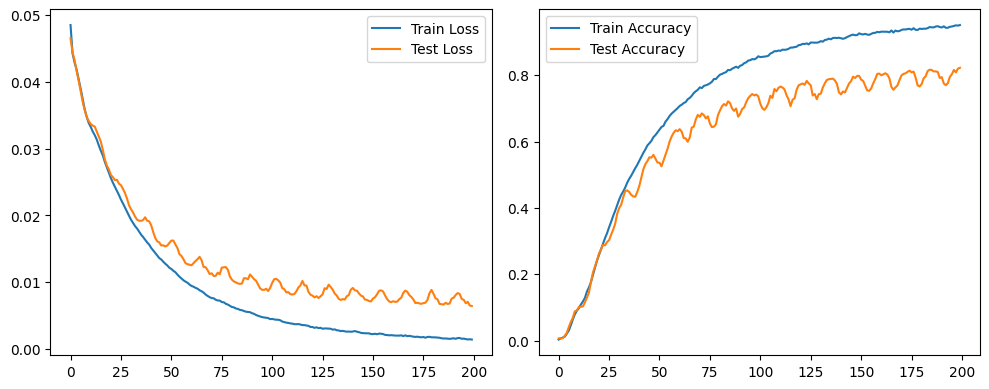

In [222]:
train_loss_5_1, train_acc_5_1, test_loss_5_1, test_acc_5_1 = train_test_loop(200, model5_1, loss_fn_5_1, optimizer_5_1, scheduler= scheduler_5_1)

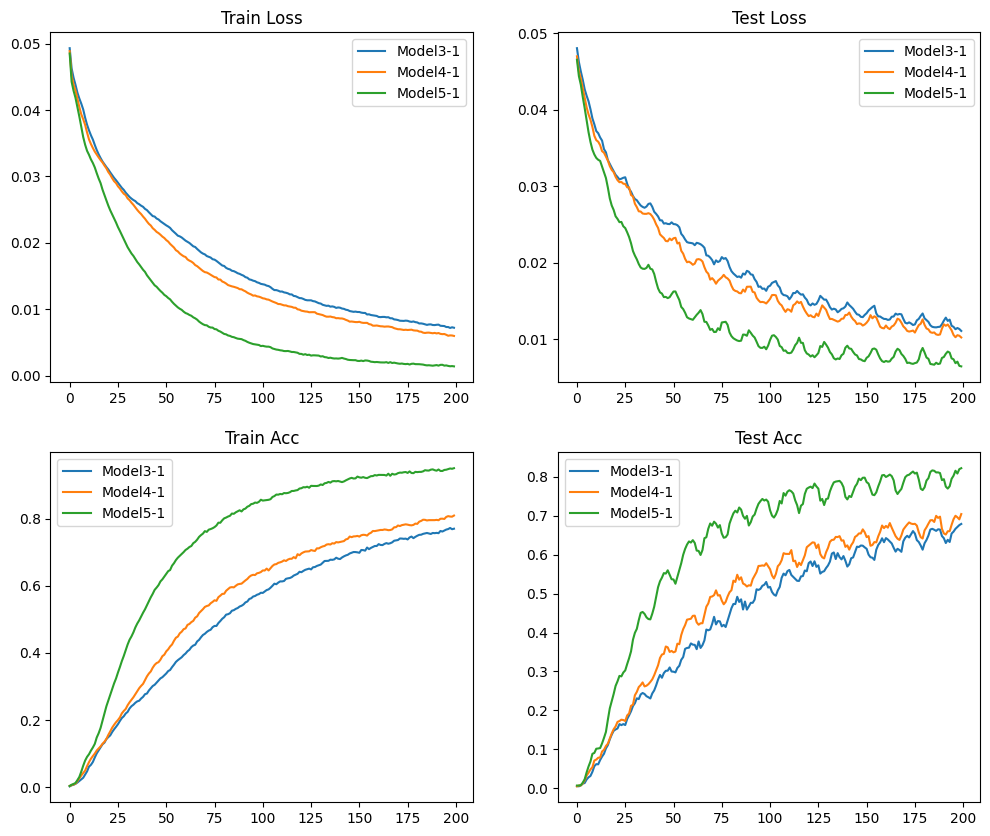

In [244]:
plt.figure(figsize = (12,10))

plt.subplot(2,2,1)
plt.plot(range(200), train_loss_3_1, label = 'Model3-1')
plt.plot(range(200), train_loss_4_1, label = 'Model4-1')
plt.plot(range(200), train_loss_5_1, label = 'Model5-1')
plt.title('Train Loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(200), test_loss_3_1, label = 'Model3-1')
plt.plot(range(200), test_loss_4_1, label = 'Model4-1')
plt.plot(range(200), test_loss_5_1, label = 'Model5-1')
plt.title('Test Loss')
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(200), train_acc_3_1, label = 'Model3-1')
plt.plot(range(200), train_acc_4_1, label = 'Model4-1')
plt.plot(range(200), train_acc_5_1, label = 'Model5-1')
plt.title('Train Acc')
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(200), test_acc_3_1, label = 'Model3-1')
plt.plot(range(200), test_acc_4_1, label = 'Model4-1')
plt.plot(range(200), test_acc_5_1, label = 'Model5-1')
plt.title('Test Acc')
plt.legend()

#### 模型比較:
1. 使用 learning rate warm up 的 Model 表現會比較好
2. gelu 表現比 relu 好
3. Conformer (test acc : 82.2%) 相較於單純的 Transformer (test acc : 70.4%)模型表現好很多，但模型也大很多 (2.3M > 823K)，導致整體 Run time 很久

## 6. 模型儲存

In [247]:
torch.save(model5_1.state_dict(), 'selfattn_model.pt')

## 7. Inference

In [285]:
class Voxdataset_test(Dataset):

    '''
    Data Structure:
    data file: 'C:\\Users\\HSUPC\\python_files\\ML2023HW4\\Dataset'
        1. mapping.json: 
            speaker2id ("id00464": 0, "id00559": 1, "id00578": 2)
            id2speaker ("0": "id00464", "1": "id00559", "2": "id00578")
        2. testdata.json:
            Similar as metadata.json only this is for testing data and without speakers(id).
            {
                "n_mels": 40,
                "utterances": [
                    {
                        "feature_path": "uttr-c943514d1fae4ae983d10e8987856b13.pt",
                        "mel_len": 452
                    },
                    {
                        "feature_path": "uttr-f8affff33d5c451c9b5856bd4764f4d9.pt",
                        "mel_len": 546
                    },...
        4. uttr-.*.pt

    '''

    def __init__(self, data_dir, segment_len = 128):

        '''
        * 128 為常見的mel頻譜的長度
        1. Load mapping data for speaker2id
        2. Load metadata or testdata
        3. Num of speaker
        4. Return a list with [file, speaker id] for __len__ and __getitem__
        '''

        self.data_dir = data_dir
        self.segment_len = segment_len

        # Load mapping.json
        # mapping_path = pathlib.Path(data_dir)/'mapping.json'
        # mapping = json.load(mapping_path.open())
        # self.speaker2id = mapping['speaker2id']

        # # Load metadata.json
        # meta_path = pathlib.Path(data_dir)/'metadata.json'
        # metadata = json.load(meta_path.open())['speakers']

        # Load testdata.json
        test_data = pathlib.Path(data_dir)/'testdata.json'
        testdata = json.load(test_data.open())['utterances']

        # # the number of speaker in data
        # self.speaker_num = len(testdata.keys())

        # return a list self.data that includes [[name of feature_path1, speaker id1], [name of feature_path2, speaker id2]...]
        self.data = []
        for utterances in testdata:
            self.data.append(utterances['feature_path'])

    
    def __len__(self):
        # return the number of data
        return len(self.data)
        

    def __getitem__(self, idx):
        # Get the indexth item from the dataset, first read the preprocessed mel-spectrogram (pt file)
        feature_path = self.data[idx]
        # speaker = torch.LongTensor([speaker])
        mel = torch.load(pathlib.Path(self.data_dir)/feature_path)

        # As the length of mel-spectrogram is decided in the beginning as an input variable, trim if the length of selected mel-spectrogram is larger.
        if len(mel) > self.segment_len:
            mel_start = random.randint(0, (len(mel) - self.segment_len))
            return torch.FloatTensor(mel[mel_start : mel_start + self.segment_len])
        else:
            return torch.FloatTensor(mel)


    # def speaker_num(self):
    #     return self.speaker_num
         

In [290]:
def collate_batch_test(batch):
    '''
    Since the length in each mel is different, need to pad them to the same length.
    This is used in Dataloader as a vaiable in collact_fn.
    '''
    mel= batch
    # padding output: Batch * padded mel length * 40, padding value = 20
    mel = pad_sequence(mel, batch_first= True, padding_value= -20)
    return mel

In [291]:
testdataset = Voxdataset_test('Dataset')

In [292]:
test_loader = DataLoader(testdataset, batch_size = 128, shuffle = False, collate_fn = collate_batch_test)

In [307]:
model6 = VoxConfomer(d_model = 256, n_spks = 600)
model6.load_state_dict(torch.load('selfattn_model.pt'))
predict = []

model6 = model6.to('cuda')
model6.eval()
with torch.inference_mode():
    for mel in tqdm(test_loader):
        mel = mel.to('cuda')
        pre = model6(mel)
        predict.append(torch.argmax(pre, dim = 1))

predict = torch.cat(predict)
    

  0%|          | 0/63 [00:00<?, ?it/s]

In [310]:
predict

tensor([334, 201, 330,  ...,  69, 174, 262], device='cuda:0')

## 8. 結論

1. Conformer 的 Paper 有提到這是用來做 ASR (automatic speech recognition) 的模型。在這裡也可以看到 Conformer結果明顯比 Transformer表現還好。
2. Learning rate Warm-up 訓練後 transformer (或 Conformer)能得到比較好的成果。
3. 目前模型用 mean pool，但 self attention model的池化也可參考 https://arxiv.org/abs/2209.07659